In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd

In [2]:
np.set_printoptions(linewidth=150)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
PT_drive = '/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/Martin_google_drive'

In [11]:
#csv combining sheets
df_helechos_18,df_helechos_19,df_helechos_20 = [pd.read_csv(f'{PT_drive}/Helechos_{year}.csv') for year in [18,19,20]]
combined = pd.concat([df_helechos_18,df_helechos_19,df_helechos_20], ignore_index=True, sort=False)
combined.columns = [str(c).strip() for c in combined.columns]
cols = ['Date', 'Month', 'Day', 'hour', 'Temp', 'RH%', 'Gastrotheca chysosticta', 'Oreobates berdemenos']
existing = [c for c in cols if c in combined.columns]
df_helechos = combined[existing].copy()
for col in ['Month', 'Day', 'hour', 'Gastrotheca chysosticta', 'Oreobates berdemenos']:
    if col in df_helechos.columns:
        df_helechos[col] = pd.to_numeric(df_helechos[col], errors='coerce').astype('Int64')


In [ ]:
#Excel opening and combining sheets
df_helechos = pd.read_excel(f'{PT_drive}/Helechos_2018-2020.xlsx', sheet_name=None)
# Concatenate all sheets into a single DataFrame
combined = pd.concat(df_helechos.values(), ignore_index=True, sort=False)
combined.columns = [str(c).strip() for c in combined.columns]
cols = ['Date', 'Month', 'Day', 'hour', 'Temp', 'RH%', 'Gastrotheca chysosticta', 'Oreobates berdemenos']
existing = [c for c in cols if c in combined.columns]
df_helechos = combined[existing].copy()
# Cast selected columns to nullable integer dtype (preserves missing values)
for col in ['Month', 'Day', 'hour', 'Gastrotheca chysosticta', 'Oreobates berdemenos']:
    if col in df_helechos.columns:
        df_helechos[col] = pd.to_numeric(df_helechos[col], errors='coerce').astype('Int64')


In [12]:
print(df_helechos.iloc[1765:1769],'\n')
print(df_helechos.iloc[2158:2163],'\n')

            Date  Month  Day  hour    Temp     RH%  Gastrotheca chysosticta  Oreobates berdemenos
1765  14/11/2018     11  318    13  13.073  99.496                        0                     0
1766  14/11/2018     11  318    14  20.082  93.190                        0                     0
1767    11/14/18     11  318    15  14.038  89.570                        0                     0
1768    11/14/18     11  318    16  13.750  92.480                        0                     0 

            Date  Month  Day  hour    Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos
2158    11/30/18     11  334    22  16.618  100.0                        0                     0
2159    11/30/18     11  334    23  16.523  100.0                        0                     0
2160  12/01/2018     12  335     0  16.523  100.0                        0                     1
2161  12/01/2018     12  335     1  16.427  100.0                        0                     0
2162  12/01/2018     12

In [13]:
df_helechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16799 entries, 0 to 16798
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     16798 non-null  object 
 1   Month                    16775 non-null  Int64  
 2   Day                      16775 non-null  Int64  
 3   hour                     16775 non-null  Int64  
 4   Temp                     13265 non-null  float64
 5   RH%                      11304 non-null  float64
 6   Gastrotheca chysosticta  13258 non-null  Int64  
 7   Oreobates berdemenos     13257 non-null  Int64  
dtypes: Int64(5), float64(2), object(1)
memory usage: 1.1+ MB


In [147]:
import re

# Standardise Date strings: if pattern is xx/xx/xxxx keep only last two year chars -> xx/xx/xx

def _shorten_year(seg: str) -> str:
    # Handles a segment that may contain trailing time (e.g., '2020 00:00:00')
    if ' ' in seg:
        year_part, rest = seg.split(' ', 1)
    else:
        year_part, rest = seg, ''
    if len(year_part) == 4:  # exactly four chars -> drop first two
        new_year = year_part[-2:]
        return new_year + (' ' + rest if rest else '')
    return seg  # leave unchanged

def shorten_date_value(v):
    if pd.isna(v):
        return v
    if isinstance(v, pd.Timestamp):
        return v  # already datetime-like, leave for later parsing
    s = str(v).strip()
    # Only process strings with exactly two '/'
    if s.count('/') == 2:
        a, b, c = s.split('/')
        c_new = _shorten_year(c)
        s_new = f"{a}/{b}/{c_new}"
        return s_new
    return s

if 'Date' in df_helechos.columns:
    df_helechos['Date'] = df_helechos['Date'].apply(shorten_date_value)

In [14]:
# date changes from dd/mm to mm/dd at row 1767

print(df_helechos.iloc[1765:1769],'\n')
df_dd_mm = df_helechos.iloc[:1767].copy()
df_mm_dd = df_helechos.iloc[1767:].copy()
print(df_dd_mm.tail(),'\n')
print(df_mm_dd.head(),'\n')
df_dd_mm['Date'] = pd.to_datetime(df_dd_mm['Date'], format='%d/%m/%Y', errors='coerce')
date_raw = df_mm_dd['Date'].astype(str).str.strip()
parsed = pd.to_datetime(date_raw, format='%m/%d/%Y', errors='coerce')
mask = parsed.isna()
if mask.any():
    parsed_alt = pd.to_datetime(date_raw[mask], format='%m/%d/%y', errors='coerce')
    parsed[mask] = parsed_alt
df_mm_dd['Date'] = parsed
df_helechos_2018_2020 = pd.concat([df_dd_mm, df_mm_dd], ignore_index=True)
print(df_helechos_2018_2020.iloc[1765:1769])


            Date  Month  Day  hour    Temp     RH%  Gastrotheca chysosticta  Oreobates berdemenos
1765  14/11/2018     11  318    13  13.073  99.496                        0                     0
1766  14/11/2018     11  318    14  20.082  93.190                        0                     0
1767    11/14/18     11  318    15  14.038  89.570                        0                     0
1768    11/14/18     11  318    16  13.750  92.480                        0                     0 

            Date  Month  Day  hour    Temp      RH%  Gastrotheca chysosticta  Oreobates berdemenos
1762  14/11/2018     11  318    10  12.572  100.000                        0                     0
1763  14/11/2018     11  318    11  12.071  100.000                        0                     0
1764  14/11/2018     11  318    12  12.572  100.000                        0                     0
1765  14/11/2018     11  318    13  13.073   99.496                        0                     0
1766  14/11/2

In [15]:
print(df_helechos_2018_2020.iloc[2158:2163],'\n')

           Date  Month  Day  hour    Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos
2158 2018-11-30     11  334    22  16.618  100.0                        0                     0
2159 2018-11-30     11  334    23  16.523  100.0                        0                     0
2160 2018-12-01     12  335     0  16.523  100.0                        0                     1
2161 2018-12-01     12  335     1  16.427  100.0                        0                     0
2162 2018-12-01     12  335     2  16.237  100.0                        0                     0 



In [16]:

# remove records where there is no annotation
df_helechos_2018_2020 = df_helechos_2018_2020[df_helechos_2018_2020['Gastrotheca chysosticta'].notna() | df_helechos_2018_2020['Oreobates berdemenos'].notna()]
# df_helechos_2018_2020 = df_helechos_2018_2020[df_helechos_2018_2020['Oreobates berdemenos'].notna()]

In [17]:
# Find records with missing (NaN / <NA>) values in 'Oreobates berdemenos'
oreobates_nan = df_helechos_2018_2020[df_helechos_2018_2020['Oreobates berdemenos'].isna()]
# Drop rows with missing 'Oreobates berdemenos' and recompute
print(oreobates_nan)
if len(oreobates_nan) > 0:
    df_helechos_2018_2020 = df_helechos_2018_2020.drop(oreobates_nan.index)
    oreobates_nan = df_helechos_2018_2020[df_helechos_2018_2020['Oreobates berdemenos'].isna()]
print(f"Number of records with NaN in 'Oreobates berdemenos': {len(oreobates_nan)}")

           Date  Month  Day  hour    Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos
1128 2018-10-19     10  292     0  21.583  81.86                        0                  <NA>
Number of records with NaN in 'Oreobates berdemenos': 0


In [18]:
# Count records where species are present
berdemenos_count = (df_helechos_2018_2020['Oreobates berdemenos'] > 0).sum()
chysosticta_count = sum(df_helechos_2018_2020['Gastrotheca chysosticta'] > 0)

# Count records where both species are present together
both_species_count = sum((df_helechos_2018_2020['Oreobates berdemenos'] > 0) & 
                         (df_helechos_2018_2020['Gastrotheca chysosticta'] > 0))

# Find dates where both species are present
both_species_present = df_helechos_2018_2020.groupby('Date').filter(
    lambda x: (x['Oreobates berdemenos'] > 0).any() and (x['Gastrotheca chysosticta'] > 0).any()
)['Date'].unique()

# Print results
print(f"Records with Oreobates berdemenos present: {berdemenos_count}")
print(f"Records with Gastrotheca chysosticta present: {chysosticta_count}")
print(f"Records with both species present together: {both_species_count}")
print(f"Number of unique dates with both species present: {len(both_species_present)}")

# Calculate percentage of co-occurrence relative to each species
if berdemenos_count > 0:
    print(f"Percentage of O. berdemenos records with G. chysosticta present: {both_species_count/berdemenos_count*100:.2f}%")
if chysosticta_count > 0:
    print(f"Percentage of G. chysosticta records with O. berdemenos present: {both_species_count/chysosticta_count*100:.2f}%")

Records with Oreobates berdemenos present: 784
Records with Gastrotheca chysosticta present: 1149
Records with both species present together: 100
Number of unique dates with both species present: 60
Percentage of O. berdemenos records with G. chysosticta present: 12.76%
Percentage of G. chysosticta records with O. berdemenos present: 8.70%


In [25]:
# Sort the DataFrame by date
df_helechos_2018_2020 = df_helechos_2018_2020.sort_values(by='Date', ascending=True)

# Display the first few rows to verify sorting
print("DataFrame sorted by date:")
print(df_helechos_2018_2020.head())

DataFrame sorted by date:
         Date  Month  Day  hour    Temp      RH%  Gastrotheca chysosticta  Oreobates berdemenos
0  2018-09-02      9  245     0   4.553  100.000                        0                     0
5  2018-09-02      9  245     5   2.547  100.000                        0                     0
6  2018-09-02      9  245     6   2.547  100.000                        0                     0
12 2018-09-02      9  245    12  10.067   94.671                        0                     0
23 2018-09-02      9  245    23   7.561   86.595                        1                     0


In [26]:
df_helechos_2018_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13257 entries, 0 to 16486
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     13257 non-null  datetime64[ns]
 1   Month                    13257 non-null  Int64         
 2   Day                      13257 non-null  Int64         
 3   hour                     13257 non-null  Int64         
 4   Temp                     13257 non-null  float64       
 5   RH%                      11303 non-null  float64       
 6   Gastrotheca chysosticta  13257 non-null  Int64         
 7   Oreobates berdemenos     13257 non-null  Int64         
dtypes: Int64(5), datetime64[ns](1), float64(2)
memory usage: 996.9 KB


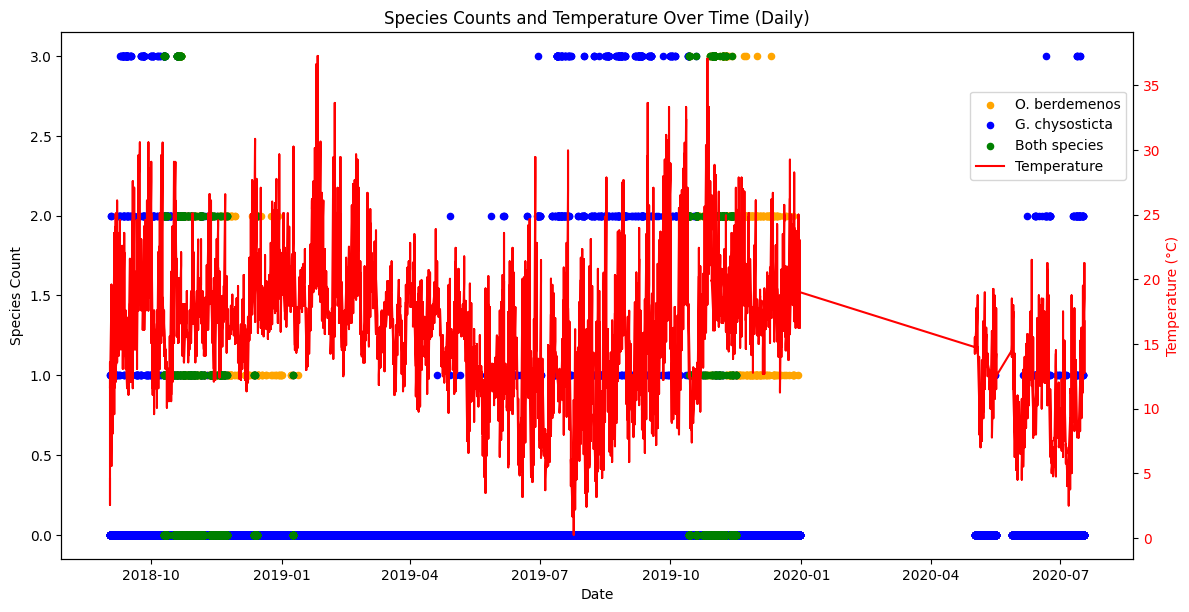

In [27]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot species counts on primary y-axis
ax1.scatter(df_helechos_2018_2020['Date'], df_helechos_2018_2020['Oreobates berdemenos'], color='orange', label='O. berdemenos', s=20, zorder=1)
ax1.scatter(df_helechos_2018_2020['Date'], df_helechos_2018_2020['Gastrotheca chysosticta'], color='blue', label='G. chysosticta', s=20, zorder=2)


# Plot green points for dates where both species are present
if len(both_species_present) > 0:
    for i, date in enumerate(both_species_present):
        filtered_data = df_helechos_2018_2020[df_helechos_2018_2020['Date']==date]
        y_values = filtered_data['Oreobates berdemenos']
        x_values = [date] * len(y_values)  # Repeat date for each y value
        #only add label for first instance to stop legend having millions of entries
        label = 'Both species' if i == 0 else ""
        ax1.scatter(x_values, y_values, color='green', s=20, label=label, zorder=3)
        ax1.scatter(x_values, filtered_data['Gastrotheca chysosticta'], color='green', s=20, label='', zorder=3)


ax1.set_xlabel('Date')
ax1.set_ylabel('Species Count', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Limit to last 6 months for better visualization
# date_max = df_helechos_2018_2020['Date'].max() - pd.DateOffset(months=2)
# date_min = df_helechos_2018_2020['Date'].max() - pd.DateOffset(months=3)
# plt.xlim(date_min, date_max)

# Create secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df_helechos_2018_2020['Date'], df_helechos_2018_2020['Temp'], 'r-', label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right',bbox_to_anchor = (1,0.9))

# Improve date formatting on x-axis
plt.xticks(rotation=45)
fig.tight_layout()

plt.title('Species Counts and Temperature Over Time (Daily)')
plt.show()

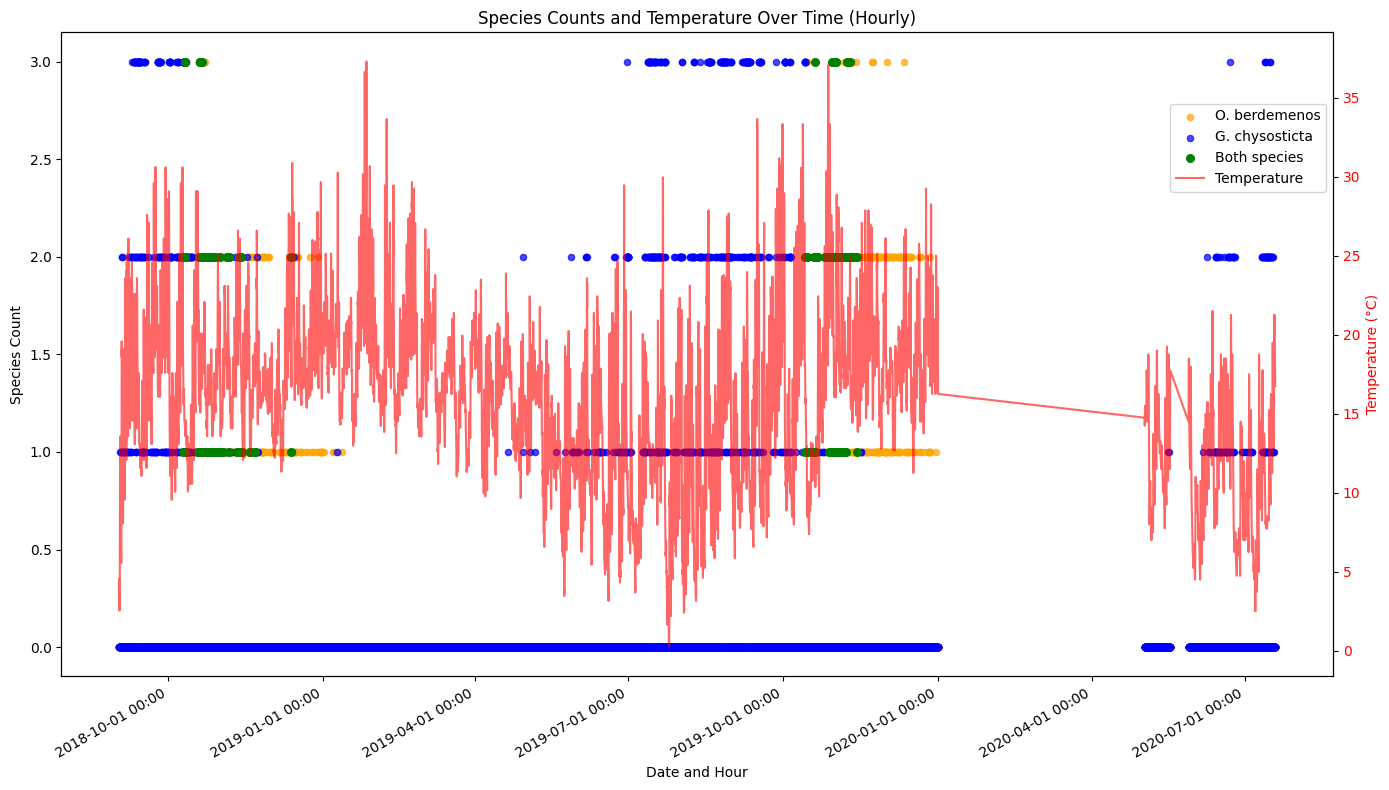

In [28]:
# Convert 'Date' and 'hour' to a combined datetime for x-axis
df_helechos_2018_2020['DateTime'] = pd.to_datetime(df_helechos_2018_2020['Date']) + pd.to_timedelta(df_helechos_2018_2020['hour'], unit='h')
# Sort DataFrame by DateTime to ensure proper chronological ordering
df_helechos_2018_2020 = df_helechos_2018_2020.sort_values(by='DateTime')
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot species counts on primary y-axis
ax1.scatter(df_helechos_2018_2020['DateTime'], df_helechos_2018_2020['Oreobates berdemenos'], 
            color='orange', label='O. berdemenos', s=20, alpha=0.7, zorder=1)
ax1.scatter(df_helechos_2018_2020['DateTime'], df_helechos_2018_2020['Gastrotheca chysosticta'], 
            color='blue', label='G. chysosticta', s=20, alpha=0.7, zorder=2)

# Find times where both species are present in the same hour
both_species_hourly = df_helechos_2018_2020[
    (df_helechos_2018_2020['Oreobates berdemenos'] > 0) & 
    (df_helechos_2018_2020['Gastrotheca chysosticta'] > 0)
]

# Plot green points for hours where both species are present
if len(both_species_hourly) > 0:
    ax1.scatter(both_species_hourly['DateTime'], both_species_hourly['Oreobates berdemenos'], 
                color='green', s=30, label='Both species', zorder=3)
    ax1.scatter(both_species_hourly['DateTime'], both_species_hourly['Gastrotheca chysosticta'], 
                color='green', s=30, label='', zorder=3)
    

ax1.set_xlabel('Date and Hour')
ax1.set_ylabel('Species Count', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df_helechos_2018_2020['DateTime'], df_helechos_2018_2020['Temp'], 'r-', linewidth=1.5, alpha=0.6, label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right',bbox_to_anchor = (1,0.9))

# # Limit to a shorter time window for better visualization with hourly data
# date_max = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=515)#
# date_min = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=520)#, 81 has lots of noise
# plt.xlim(date_min, date_max)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Species Counts and Temperature Over Time (Hourly)')
plt.tight_layout()
plt.show()

In [29]:
df_helechos_2018_2020.head()

,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos,DateTime
0,2018-09-02,9,245,0,4.553,100.0,0,0,2018-09-02 00:00:00
1,2018-09-02,9,245,1,4.051,100.0,0,0,2018-09-02 01:00:00
2,2018-09-02,9,245,2,4.553,100.0,0,0,2018-09-02 02:00:00
3,2018-09-02,9,245,3,3.550,100.0,0,0,2018-09-02 03:00:00
4,2018-09-02,9,245,4,3.048,100.0,0,0,2018-09-02 04:00:00


In [30]:
# Group records by DateTime and count the occurrences
datetime_counts = df_helechos_2018_2020.groupby('DateTime').size().reset_index(name='count')

# Show the distribution of counts
print(f"Total number of unique DateTimes: {len(datetime_counts)}")
print(f"DateTimes with multiple records: {sum(datetime_counts['count'] > 1)}")
print("\nDistribution of records per DateTime:")
print(datetime_counts['count'].value_counts().sort_index())

# Identify the DateTimes with the most records
print("\nDateTimes with the most records:")
most_records = datetime_counts.sort_values(by='count', ascending=False).head(5)
print(most_records)

# Show examples of duplicate DateTimes
if sum(datetime_counts['count'] > 1) > 0:
    print("\nExample of records with the same DateTime:")
    duplicate_datetime = datetime_counts[datetime_counts['count'] > 1]['DateTime'].iloc[0]
    print(df_helechos_2018_2020[df_helechos_2018_2020['DateTime'] == duplicate_datetime])

Total number of unique DateTimes: 13257
DateTimes with multiple records: 0

Distribution of records per DateTime:
count
1    13257
Name: count, dtype: int64

DateTimes with the most records:
                DateTime  count
0    2018-09-02 00:00:00      1
8842 2019-09-05 11:00:00      1
8832 2019-09-05 01:00:00      1
8833 2019-09-05 02:00:00      1
8834 2019-09-05 03:00:00      1


In [31]:
print(df_helechos_2018_2020.head())
df_helechos_2018_2020.tail(15)

        Date  Month  Day  hour   Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos            DateTime
0 2018-09-02      9  245     0  4.553  100.0                        0                     0 2018-09-02 00:00:00
1 2018-09-02      9  245     1  4.051  100.0                        0                     0 2018-09-02 01:00:00
2 2018-09-02      9  245     2  4.553  100.0                        0                     0 2018-09-02 02:00:00
3 2018-09-02      9  245     3  3.550  100.0                        0                     0 2018-09-02 03:00:00
4 2018-09-02      9  245     4  3.048  100.0                        0                     0 2018-09-02 04:00:00


,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos,DateTime
16472,2020-07-18,7,200,9,21.25,NaN,0,0,2020-07-18 09:00:00
16473,2020-07-18,7,200,10,21.25,NaN,0,0,2020-07-18 10:00:00
16474,2020-07-18,7,200,11,21.00,NaN,0,0,2020-07-18 11:00:00
16475,2020-07-18,7,200,12,21.25,NaN,0,0,2020-07-18 12:00:00
16476,2020-07-18,7,200,13,19.00,NaN,0,0,2020-07-18 13:00:00
16477,2020-07-18,7,200,14,18.75,NaN,0,0,2020-07-18 14:00:00
16478,2020-07-18,7,200,15,18.50,NaN,0,0,2020-07-18 15:00:00
16479,2020-07-18,7,200,16,18.50,NaN,0,0,2020-07-18 16:00:00
16480,2020-07-18,7,200,17,18.25,NaN,0,0,2020-07-18 17:00:00
16481,2020-07-18,7,200,18,18.00,NaN,0,0,2020-07-18 18:00:00


# clean all columns, either interpolate or remove records without full data

In [42]:
# Missing (invalid) entry counts per column for df_helechos_2018_2020
missing_counts = df_helechos_2018_2020.isna().sum()
missing_summary = (
    missing_counts.to_frame(name='missing')
    .assign(total=len(df_helechos_2018_2020),
            percent=lambda d: d['missing'] / d['total'] * 100)
)

print("Missing value summary (NaN / <NA>):")
print(missing_summary)

# If you also want rows that have any missing field:
rows_with_any_missing = df_helechos_2018_2020.isna().any(axis=1).sum()
print(f"\nRows with at least one missing value: {rows_with_any_missing} "
      f"({rows_with_any_missing/len(df_helechos_2018_2020)*100:.2f}%)")

Missing value summary (NaN / <NA>):
                         missing  total    percent
Date                           0  13257   0.000000
Month                          0  13257   0.000000
Day                            0  13257   0.000000
hour                           0  13257   0.000000
Temp                           0  13257   0.000000
RH%                         1954  13257  14.739383
Gastrotheca chysosticta        0  13257   0.000000
Oreobates berdemenos           0  13257   0.000000
DateTime                       0  13257   0.000000

Rows with at least one missing value: 1954 (14.74%)


In [43]:
# Remove rows with missing RH%
before = len(df_helechos_2018_2020)
df_helechos_2018_2020 = df_helechos_2018_2020[df_helechos_2018_2020['RH%'].notna()].copy()
after = len(df_helechos_2018_2020)
print(f"Removed {before - after} rows with missing RH%. Remaining rows: {after}")

Removed 1954 rows with missing RH%. Remaining rows: 11303


# NODE

In [44]:
import math
import torch
from torchdiffeq import odeint
import sys, subprocess

# Neural ODE fit for O. berdemenos and G. chysosticta using environmental covariates

# 1) Setup: imports (only those not already in the notebook) and device
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# 2) Prepare time series, targets, and features
df = df_helechos_2018_2020.copy()

# Ensure chronological order by DateTime (created earlier)
# df = df.sort_values("DateTime").reset_index(drop=True)

# Handle missing target values
s1_col = "Oreobates berdemenos"
s2_col = "Gastrotheca chysosticta"
df[s1_col] = df[s1_col].interpolate().bfill().ffill()
df[s2_col] = df[s2_col].astype(float)

# Time normalization to [0, 1]
t_seconds = (df["DateTime"] - df["DateTime"].iloc[0]).dt.total_seconds().values
t_norm = (t_seconds - t_seconds.min()) / (t_seconds.max() - t_seconds.min())
t = torch.tensor(t_norm, dtype=torch.float32, device=device)  # (N,)

[0.00000e+00 3.60000e+03 7.20000e+03 ... 4.06836e+07 4.06872e+07 4.06908e+07]
tensor([0.0000e+00, 8.8472e-05, 1.7694e-04,  ..., 9.9982e-01, 9.9991e-01,
        1.0000e+00])
Is t monotonically increasing? True
Minimum difference: 8.845329284667969e-05
Maximum difference: 0.000176943838596344
Mean difference: 8.847991557558998e-05


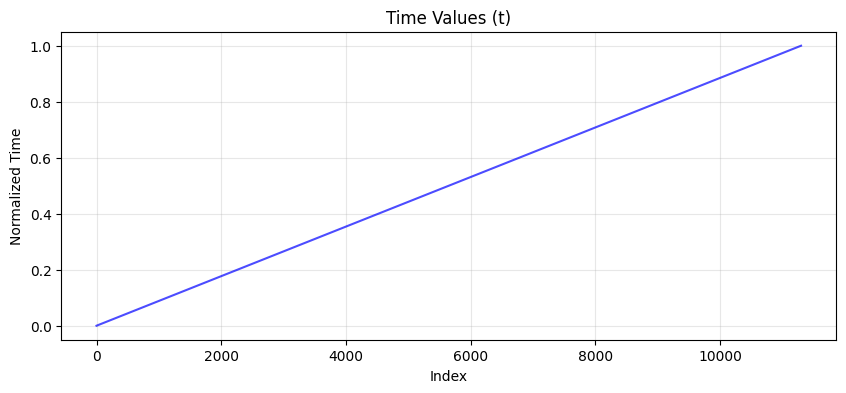

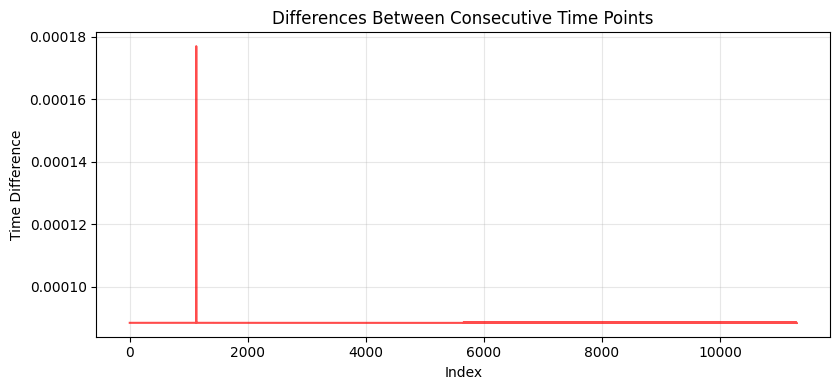

In [46]:
df = df_helechos_2018_2020.copy()

df.head()
print(t_seconds)
print(t)
# Check if t is monotonically increasing
is_monotonic = all(t[i] <= t[i+1] for i in range(len(t)-1))
print(f"Is t monotonically increasing? {is_monotonic}")

# Check the differences between consecutive elements
t_diff = t[1:] - t[:-1]
t_diff_log = torch.log(t_diff + 1e-8)  # log-transform to see relative changes
print(f"Minimum difference: {t_diff.min().item()}")
print(f"Maximum difference: {t_diff.max().item()}")
print(f"Mean difference: {t_diff.mean().item()}")

# Plot the time values to visualize
plt.figure(figsize=(10, 4))
plt.plot(t.numpy(), 'b-', alpha=0.7)
plt.title('Time Values (t)')
plt.ylabel('Normalized Time')
plt.xlabel('Index')
plt.grid(True, alpha=0.3)

# Plot the differences between consecutive time points
plt.figure(figsize=(8.5, 4))
plt.plot(t_diff.numpy(), 'r-', alpha=0.7)
plt.title('Differences Between Consecutive Time Points')
plt.ylabel('Time Difference')
plt.xlabel('Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Epoch    1/200  MSE: 1.065904
Epoch   25/200  MSE: 0.941203
Epoch   50/200  MSE: 0.912905
Epoch   75/200  MSE: 0.896348
Epoch  100/200  MSE: 0.882864
Epoch  125/200  MSE: 0.872919
Epoch  150/200  MSE: 0.865497
Epoch  175/200  MSE: 0.860026
Epoch  200/200  MSE: 0.854490


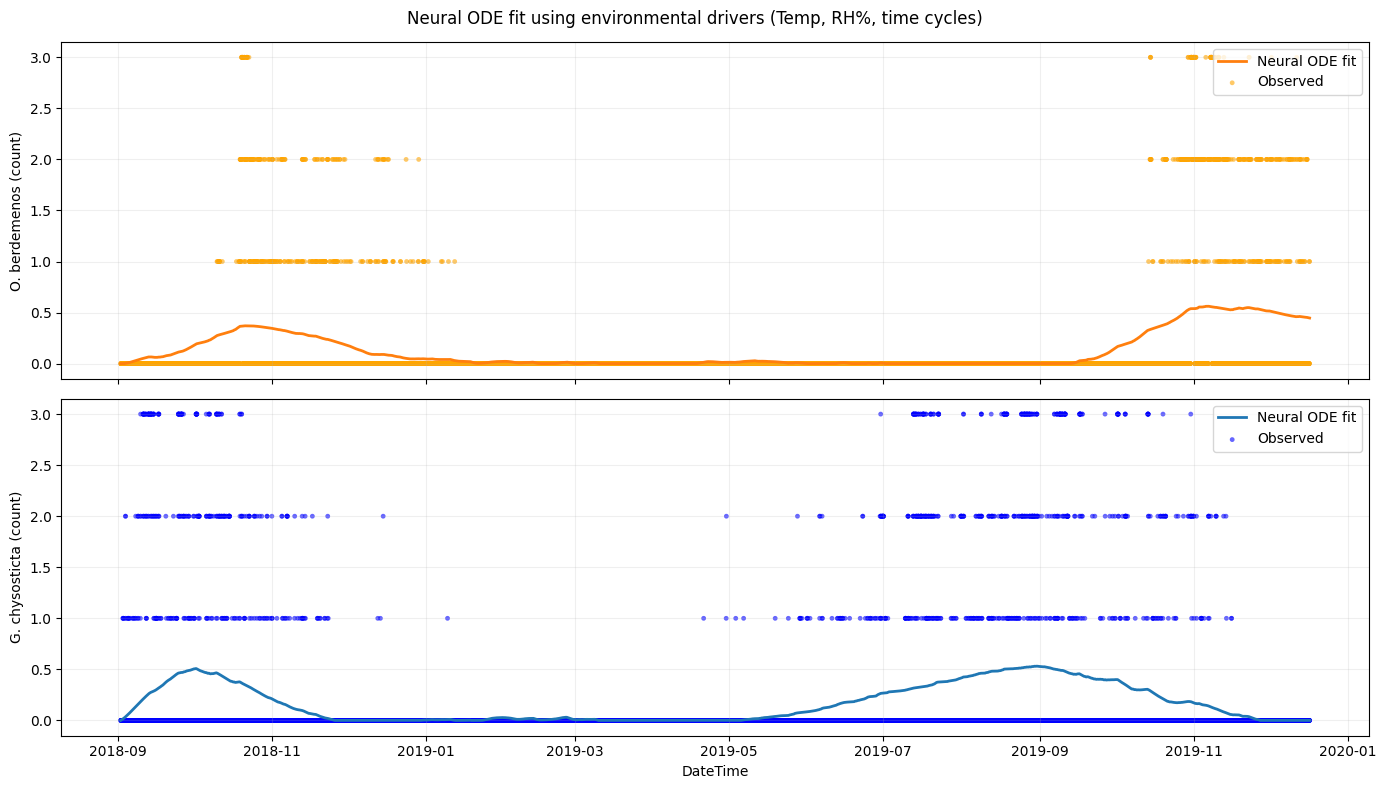

Final normalized MSE: 0.854298


In [47]:

# Targets (2D state): [O. berdemenos, G. chysosticta]
Y_np = df[[s1_col, s2_col]].values.astype("float32")
# Standardize targets
y_mean = torch.tensor(Y_np.mean(axis=0), dtype=torch.float32, device=device)
y_std = torch.tensor(Y_np.std(axis=0) + 1e-6, dtype=torch.float32, device=device)
Y = torch.tensor(Y_np, dtype=torch.float32, device=device)
Y_norm = (Y - y_mean) / y_std  # (N, 2)

# Exogenous features U(t): Temp, RH%, cyclical encodings for hour and day-of-year
# cyclical encodings to aid learning periodic patterns
hour = df["hour"].values.astype("float32")
dayofyear = df["DateTime"].dt.dayofyear.values.astype("float32")
temp = df["Temp"].values.astype("float32")
rh = df["RH%"].values.astype("float32")

hour_sin = np.sin(2 * np.pi * hour / 24.0)
hour_cos = np.cos(2 * np.pi * hour / 24.0)
day_sin = np.sin(2 * np.pi * dayofyear / 365.0)
day_cos = np.cos(2 * np.pi * dayofyear / 365.0)

U_np = np.stack([temp, rh, hour_sin, hour_cos, day_sin, day_cos], axis=1).astype("float32")

# Standardize features
U_mean = torch.tensor(U_np.mean(axis=0), dtype=torch.float32, device=device)
U_std = torch.tensor(U_np.std(axis=0) + 1e-6, dtype=torch.float32, device=device)
U = torch.tensor(U_np, dtype=torch.float32, device=device)
U_norm = (U - U_mean) / U_std  # (N, F)

# 3) Define Neural ODE: dy/dt = f_theta(t, y, u(t))
class ODEFunc(nn.Module):
    def __init__(self, U_aligned: torch.Tensor):
        super().__init__()
        self.U = U_aligned  # (N, F)
        self.N = U_aligned.shape[0]
        feat_dim = U_aligned.shape[1]
        state_dim = 2
        hidden = 64
        self.net = nn.Sequential(
            nn.Linear(state_dim + feat_dim + 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, state_dim),
        )

    def sample_u(self, t_scalar: torch.Tensor) -> torch.Tensor:
        # t_scalar in [0,1]; nearest-neighbor sampling of U(t)
        idx = torch.clamp(torch.round(t_scalar * (self.N - 1)).long(), 0, self.N - 1)
        u = self.U[idx]  # (F,)
        if u.dim() == 1:
            u = u.unsqueeze(0)  # (1, F)
        return u

    def forward(self, t_scalar: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # y: (2,) or (B, 2)
        y_in = y if y.dim() > 1 else y.unsqueeze(0)  # (B, 2)
        u = self.sample_u(t_scalar)  # (B, F)
        t_enc = torch.stack(
            [torch.sin(2 * math.pi * t_scalar), torch.cos(2 * math.pi * t_scalar)]
        ).to(y_in.device).unsqueeze(0).expand(y_in.shape[0], -1)  # (B, 2)
        x = torch.cat([y_in, u, t_enc], dim=-1)  # (B, 2+F+2)
        dy = self.net(x)  # (B, 2)
        return dy if y.dim() > 1 else dy.squeeze(0)

func = ODEFunc(U_norm).to(device)

# 4) Train Neural ODE end-to-end by matching the full observed trajectory
y0 = Y_norm[0]              # initial state (2,)
dt = float(t[1].item() - t[0].item()) if len(t) > 1 else 1.0
optimizer = torch.optim.Adam(func.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

epochs = 200
for ep in range(1, epochs + 1):
    optimizer.zero_grad()
    # Integrate from y0 across all evaluation times t
    Yhat_norm = odeint(func, y0, t, method="rk4", options={"step_size": dt})  # (N, 2)
    loss = loss_fn(Yhat_norm, Y_norm)
    loss.backward()
    optimizer.step()
    if ep % 25 == 0 or ep == 1:
        print(f"Epoch {ep:4d}/{epochs}  MSE: {loss.item():.6f}")

# 5) Final prediction and inverse-transform to original scale
with torch.no_grad():
    Yhat_norm = odeint(func, y0, t, method="rk4", options={"step_size": dt})  # (N, 2)
Yhat = Yhat_norm * y_std + y_mean  # (N, 2)

# 6) Plot: Predicted vs Observed over time for both species
time_index = df["DateTime"].values
yhat_np = Yhat.detach().cpu().numpy()
yhat_np = np.clip(yhat_np, a_min=0.0, a_max=None)  # counts cannot be negative

fig_fit, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# O. berdemenos
axs[0].plot(time_index, yhat_np[:, 0], color="tab:orange", label="Neural ODE fit", linewidth=2)
axs[0].scatter(time_index, df[s1_col].values, s=12, alpha=0.6, color="orange", edgecolor="none", label="Observed")
axs[0].set_ylabel("O. berdemenos (count)")
axs[0].legend(loc="upper right")
axs[0].grid(True, alpha=0.2)

# G. chysosticta
axs[1].plot(time_index, yhat_np[:, 1], color="tab:blue", label="Neural ODE fit", linewidth=2)
axs[1].scatter(time_index, df[s2_col].values, s=12, alpha=0.6, color="blue", edgecolor="none", label="Observed")
axs[1].set_ylabel("G. chysosticta (count)")
axs[1].set_xlabel("DateTime")
axs[1].legend(loc="upper right")
axs[1].grid(True, alpha=0.2)

fig_fit.suptitle("Neural ODE fit using environmental drivers (Temp, RH%, time cycles)")
plt.tight_layout()
plt.show()

# 7) Report final training error
with torch.no_grad():
    final_mse = loss_fn(Yhat_norm, Y_norm).item()
print(f"Final normalized MSE: {final_mse:.6f}")

In [48]:
# === Neural ODE per frog species; other species as exogenous features ===
import math, numpy as np, torch, torch.nn as nn
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Base DataFrame
df_base = df_helechos_2018_2020.copy()

# Ensure DateTime
if 'DateTime' not in df_base.columns:
    df_base['DateTime'] = pd.to_datetime(df_base['Date']) + pd.to_timedelta(df_base['hour'], unit='h')

# Keep needed columns (extend species list if more present later)
env_cols = [c for c in ['Temp','RH%','hour'] if c in df_base.columns]
species_cols = [c for c in ['Oreobates berdemenos','Gastrotheca chysosticta'] if c in df_base.columns]

# Drop rows without DateTime
df_base = df_base[df_base['DateTime'].notna()].copy()

# Aggregate duplicates at DateTime (mean for counts/env; first for hour)
agg_map = {c: 'mean' for c in species_cols + [c for c in env_cols if c != 'hour']}
if 'hour' in df_base.columns:
    agg_map['hour'] = 'first'
df_base = df_base.groupby('DateTime', as_index=False).agg(agg_map).sort_values('DateTime').reset_index(drop=True)

# Interpolate environmental vars
for c in env_cols:
    df_base[c] = pd.to_numeric(df_base[c], errors='coerce').astype(float).interpolate().bfill().ffill()

# Interpolate species counts (leave zeros as zeros)
for sc in species_cols:
    df_base[sc] = pd.to_numeric(df_base[sc], errors='coerce').astype(float).interpolate().bfill().ffill()
    df_base[sc] = df_base[sc].clip(lower=0)

# Time normalization
t_seconds = (df_base['DateTime'] - df_base['DateTime'].iloc[0]).dt.total_seconds().values.astype('float64')
# Enforce strictly increasing
eps = 1e-3
for i in range(1, len(t_seconds)):
    if t_seconds[i] <= t_seconds[i-1]:
        t_seconds[i] = t_seconds[i-1] + eps
t_norm = (t_seconds - t_seconds.min()) / (t_seconds.max() - t_seconds.min())
t_all = torch.tensor(t_norm, dtype=torch.float32, device=device)

# Pre-compute time encodings
doy = df_base['DateTime'].dt.dayofyear.values.astype('float32')
hour = df_base['hour'].values.astype('float32') if 'hour' in df_base.columns else np.zeros(len(df_base), dtype='float32')
time_feats_np = np.stack([
    np.sin(2*np.pi*hour/24.0),
    np.cos(2*np.pi*hour/24.0),
    np.sin(2*np.pi*doy/365.0),
    np.cos(2*np.pi*doy/365.0)
], axis=1).astype('float32')

# Environmental features
env_arrays = []
if 'Temp' in df_base.columns: env_arrays.append(df_base['Temp'].values.astype('float32'))
if 'RH%' in df_base.columns: env_arrays.append(df_base['RH%'].values.astype('float32'))
if not env_arrays:
    env_stack = np.zeros((len(df_base),0), dtype='float32')
else:
    env_stack = np.stack(env_arrays, axis=1).astype('float32')

results = {}
predictions_collect = []

class ODEFunc1D(nn.Module):
    def __init__(self, U_aligned: torch.Tensor):
        super().__init__()
        self.U = U_aligned
        self.N, feat_dim = U_aligned.shape
        hidden = 64
        self.net = nn.Sequential(
            nn.Linear(1 + feat_dim + 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )
    def sample_u(self, t_scalar: torch.Tensor):
        idx = torch.clamp(torch.round(t_scalar * (self.N - 1)).long(), 0, self.N - 1)
        u = self.U[idx]
        if u.dim() == 1: u = u.unsqueeze(0)
        return u
    def forward(self, t_scalar, y):
        y_in = y if y.dim() > 1 else y.unsqueeze(0)
        u = self.sample_u(t_scalar)
        t_enc = torch.stack([torch.sin(2*math.pi*t_scalar), torch.cos(2*math.pi*t_scalar)]
                            ).to(y_in.device).unsqueeze(0).expand(y_in.shape[0], -1)
        x = torch.cat([y_in, u, t_enc], dim=-1)
        return self.net(x) if y.dim() > 1 else self.net(x).squeeze(0)

for target in species_cols:
    print(f"\n=== Training Neural ODE for target: {target} (others exogenous) ===")
    # Build feature matrix: env + time cyc + other species (excluding target)
    other_species = [s for s in species_cols if s != target]
    other_mat = df_base[other_species].values.astype('float32') if other_species else np.zeros((len(df_base),0),'float32')
    U_np = np.concatenate([env_stack, time_feats_np, other_mat], axis=1).astype('float32')
    # Standardize features
    U_mean = U_np.mean(axis=0, keepdims=True)
    U_std = U_np.std(axis=0, keepdims=True) + 1e-6
    U_norm_np = (U_np - U_mean) / U_std
    U_tensor = torch.tensor(U_norm_np, dtype=torch.float32, device=device)

    # Target series
    y_np = df_base[target].values.astype('float32')
    y_mean = y_np.mean()
    y_std = y_np.std() + 1e-6
    y_norm = (y_np - y_mean) / y_std
    Y_tensor = torch.tensor(y_norm, dtype=torch.float32, device=device)

    func = ODEFunc1D(U_tensor).to(device)
    y0 = Y_tensor[0:1]  # shape (1,)
    dt = float((t_all[1]-t_all[0]).item()) if len(t_all) > 1 else 1.0

    optimizer = torch.optim.Adam(func.parameters(), lr=5e-3)
    loss_fn = nn.MSELoss()
    epochs = 250

    for ep in range(1, epochs+1):
        optimizer.zero_grad()
        Yhat_norm = odeint(func, y0, t_all, method="rk4", options={"step_size": dt}).squeeze(-1)  # (N,)
        loss = loss_fn(Yhat_norm, Y_tensor)
        if torch.isnan(loss):
            print("NaN loss encountered. Stopping.")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(func.parameters(), 5.0)
        optimizer.step()
        if ep % 50 == 0 or ep == 1:
            print(f"Epoch {ep:4d}/{epochs}  MSE: {loss.item():.6f}")

    with torch.no_grad():
        Yhat_norm = odeint(func, y0, t_all, method="rk4", options={"step_size": dt}).squeeze(-1)
        final_mse = loss_fn(Yhat_norm, Y_tensor).item()
        Yhat = (Yhat_norm.cpu().numpy() * y_std) + y_mean
        Yhat = np.clip(Yhat, 0, None)

    results[target] = {
        "mse_norm": final_mse,
        "y_mean": y_mean,
        "y_std": y_std,
        "U_mean": U_mean,
        "U_std": U_std,
        "pred": Yhat,
        "true": y_np
    }

    # Collect predictions for combined DataFrame
    predictions_collect.append(pd.DataFrame({
        'DateTime': df_base['DateTime'],
        'species': target,
        'observed': y_np,
        'predicted': Yhat
    }))

# Combined predictions DataFrame
predictions_df = pd.concat(predictions_collect, ignore_index=True)

print("\nSummary (normalized MSE per species):")
for k,v in results.items():
    print(f"{k}: {v['mse_norm']:.6f}")

# Plot per-species fits
n = len(species_cols)
fig, axs = plt.subplots(n, 1, figsize=(14, 4*n), sharex=True)
if n == 1: axs = [axs]
time_index = df_base['DateTime'].values
for ax, sp in zip(axs, species_cols):
    ax.plot(time_index, results[sp]['pred'], label='Neural ODE fit', color='tab:orange')
    ax.scatter(time_index, results[sp]['true'], s=10, alpha=0.5, color='tab:blue', label='Observed')
    ax.set_ylabel(sp)
    ax.grid(alpha=0.2)
    ax.legend(loc='upper right')
axs[-1].set_xlabel("DateTime")
fig.suptitle("Neural ODE per species (others + env as exogenous)")
plt.tight_layout()
plt.show()

# predictions_df now holds long-format results
predictions_df.head()


=== Training Neural ODE for target: Oreobates berdemenos (others exogenous) ===
Epoch    1/250  MSE: 1.030195


KeyboardInterrupt: 